# TF-IDF Example from scikit-learn docs

Adapted from:

https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

In [ ]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
CPA = pd.read_csv("../data/processed/CPA_tokenized.csv")
CPA.drop('Unnamed: 0', axis=1, inplace=True)
CPA.head()

In [ ]:
# Create categories for Level 1 and Level 2 higherarchies
CPA2 = CPA.copy()
#get highest level of code
CPA2.loc[CPA2.Level !=1,'Category_2'] = CPA2[CPA2.Level !=1].Code.str.split('.').str.slice(0,1).str.join('')

# match up codes and parents
Code_parent = CPA2[CPA2.Level==2][['Parent','Category_2']].copy()
CPA2 = CPA2.merge(Code_parent.rename(columns={'Parent':'Category_1'}), on='Category_2', how='left')

# add in the Category_1 fileds for Level1
CPA2.loc[CPA2.Level==1, 'Category_1'] = CPA2.loc[CPA2.Level==1,'Code']

# we now set up a higher level for A10 indstry levels (10 categories)
update_dict0 = {'A':1,'F':3,'J':5, 'K':6, 'L':7,'M':8,'N':8}
update_dict = {**update_dict0,**dict.fromkeys(['B','C','D','E'],2),**dict.fromkeys(['G','H','I'],4),
               **dict.fromkeys(['O','P','Q'],9), **dict.fromkeys(['R','S','T','U'],10)}

CPA2['Category_0'] = CPA2.Category_1.replace(update_dict)
#CPA2 = CPA2.astype({'Category_0':int})
CPA2.head()

In [ ]:
CPA2[['Code','tokens','Category_1','Category_0']].sample(7)

In [5]:
# We now create an example based on Level 6 data
CPA_L6 = CPA2[CPA2.Level==6]
CPA_L6.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1


## Notes on using TFIDF
CountVectorizer implements both tokenization and occurrence counting in a single class

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model

See also [scikit-learn on clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [6]:
# now reapeat using the ngram character vectorizer
char_ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(5, 5))
X3 = char_ngram_vectorizer.fit_transform(CPA_L6.tokens)

In [7]:
%pprint

Pretty printing has been turned OFF


In [8]:
char_ngram_vectorizer.get_feature_names()[160:240]

[' bags', ' bake', ' baki', ' bala', ' bale', ' ball', ' bals', ' bamb', ' band', ' bank', ' barb', ' baro', ' bars', ' base', ' basi', ' bask', ' bast', ' bath', ' batt', ' bayo', ' beac', ' bead', ' beam', ' bean', ' bear', ' beau', ' bed ', ' bedr', ' beds', ' bee-', ' beer', ' beet', ' bein', ' belt', ' bend', ' bene', ' bent', ' berr', ' bert', ' beta', ' bett', ' beve', ' bib ', ' bicy', ' bide', ' bifu', ' bill', ' bind', ' bing', ' bino', ' bioh', ' biol', ' biot', ' bird', ' bisc', ' bitu', ' blac', ' blad', ' blan', ' blas', ' blaz', ' blin', ' bloc', ' bloo', ' blou', ' blow', ' boar', ' boat', ' bobb', ' bodi', ' bodk', ' body', ' boil', ' bold', ' bolt', ' bond', ' bone', ' book', ' boot', ' bora']

In [9]:
tfidf_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])
tfidf_pipeline2 = Pipeline([
    ('char_vect', char_ngram_vectorizer),
    ('tfidf', TfidfTransformer()),
])

In [10]:
tfidf_pipeline1.fit(CPA_L6.tokens)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])

In [11]:
tfidf_pipeline2.fit(CPA_L6.tokens)

Pipeline(steps=[('char_vect',
                 CountVectorizer(analyzer='char', ngram_range=(5, 5))),
                ('tfidf', TfidfTransformer())])

# Simple visualisation - PCA

Adapted from

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA

X = tfidf_pipeline2.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1
#target_names = ''

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# plt.show()

In [13]:
df = CPA_L6.copy()
df['PCA_X'] = X_r[:,0]
df['PCA_Y'] = X_r[:,1]
df.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,PCA_X,PCA_Y
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-0.034505,-0.055988
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-0.034628,-0.056392
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-0.034390,-0.055594
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-0.034188,-0.054953
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-0.033753,-0.053562


<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

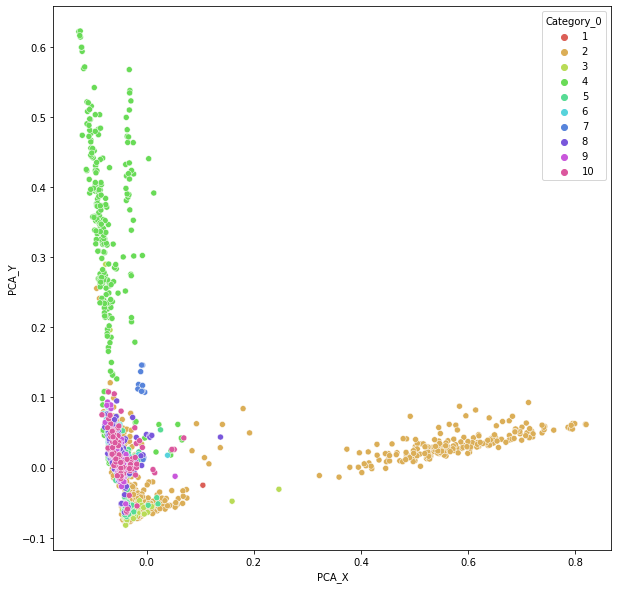

In [14]:
my_palette = sns.color_palette("hls", 10)
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='PCA_X', y='PCA_Y', hue='Category_0', palette=my_palette)

# T-SNE visualisation

Adapted from: https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization

Not so good above 4 dimensions

In [15]:
from sklearn.manifold import TSNE


X = tfidf_pipeline2.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1


pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=10)

tsne_data = model.fit_transform(X_r)

tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3218 samples in 0.006s...
[t-SNE] Computed neighbors for 3218 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3218
[t-SNE] Computed conditional probabilities for sample 2000 / 3218
[t-SNE] Computed conditional probabilities for sample 3000 / 3218
[t-SNE] Computed conditional probabilities for sample 3218 / 3218
[t-SNE] Mean sigma: 0.007015
[t-SNE] Computed conditional probabilities in 0.414s
[t-SNE] Iteration 50: error = 71.5934296, gradient norm = 0.0664012 (50 iterations in 1.174s)
[t-SNE] Iteration 100: error = 64.4503174, gradient norm = 0.0106580 (50 iterations in 0.916s)
[t-SNE] Iteration 150: error = 63.7156296, gradient norm = 0.0058617 (50 iterations in 0.829s)
[t-SNE] Iteration 200: error = 63.4498825, gradient norm = 0.0058701 (50 iterations in 0.848s)
[t-SNE] Iteration 250: error = 63.2465820, gradient norm = 0.0030430 (50 iterations in 0.898s)
[t-SNE] KL divergence after 250 iterat

In [16]:
df2 = CPA_L6.copy()
df2['dim1'] = tsne_data[:,0]
df2['dim2'] = tsne_data[:,1]
df2.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-24.193695,4.623124
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-25.404690,4.582294
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-22.944532,4.571864
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-20.857653,4.724905
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-17.669893,2.853861


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

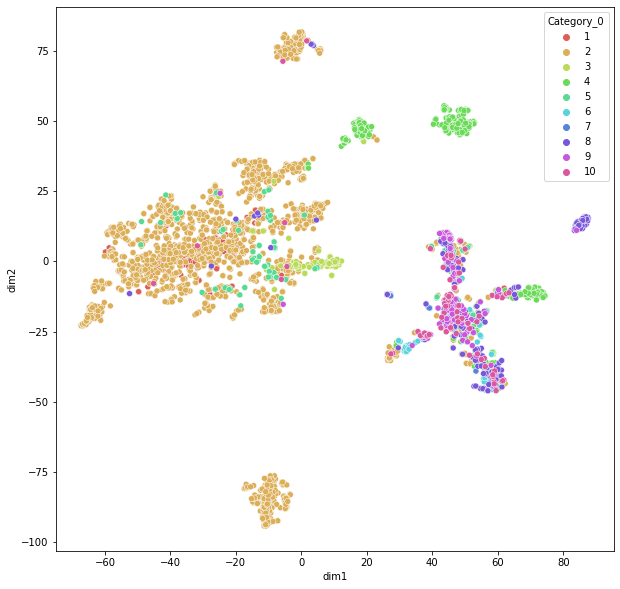

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df2,x='dim1', y='dim2', hue='Category_0',  palette=my_palette)

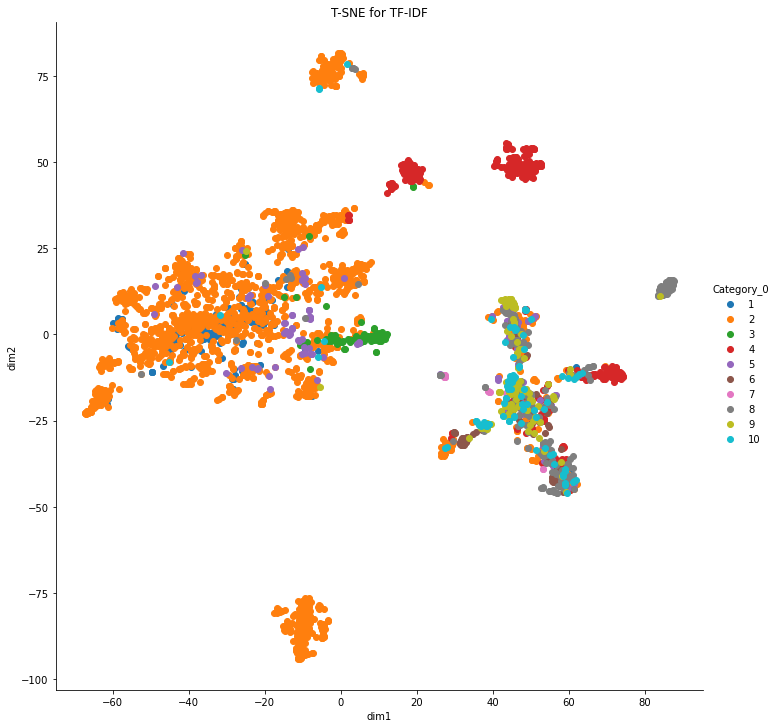

In [18]:
#sns.FacetGrid(tsne_df, hue="category", size=6, legend=None).map(plt.scatter, 'dim1', 'dim2').add_legend()
sns.FacetGrid(df2, hue="Category_0", height=10).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("T-SNE for TF-IDF");

In [19]:
import sklearn.metrics.pairwise

In [20]:
distance_matrix = sklearn.metrics.pairwise.cosine_distances(X)

<Figure size 432x288 with 0 Axes>

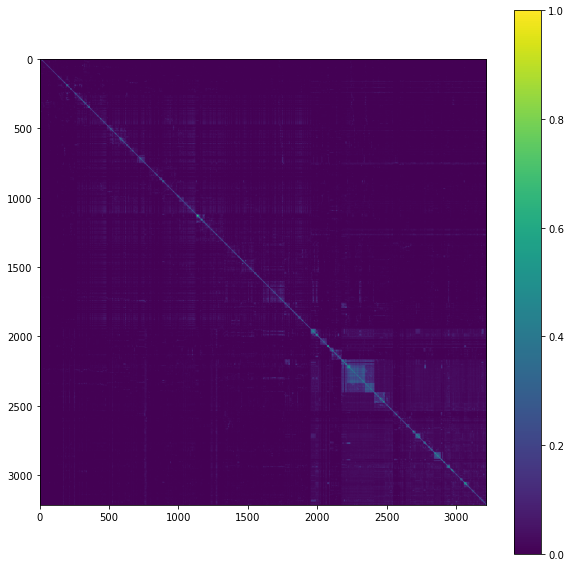

In [21]:
plt.set_cmap("viridis")
plt.figure(figsize=(10, 10))
plt.imshow(1-distance_matrix)
plt.colorbar();

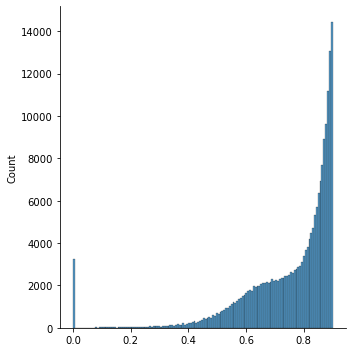

In [22]:
test = distance_matrix.flatten()
sns.displot(test[test<0.9])

<Figure size 720x720 with 0 Axes>

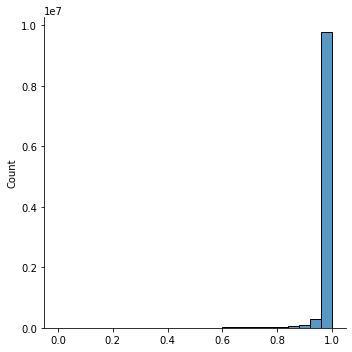

In [23]:
plt.figure(figsize=(10, 10))
sns.displot(distance_matrix.flatten())

## Discussion points:
* Curse of dimensionality
* Uni-modal pairwise distance distribution
* Dimensionality reduction
* Clustering e.g. HDBSCAN

## UMAP example

In [24]:
# u-map
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [25]:
sns.set(style='white', rc={'figure.figsize':(10,8)})